<h3>Example of tuning hyperparameters</h3>

In [32]:
#Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


In [2]:
#Loading dataset 
df = pd.read_csv ('e:/job/ml/ads/Social_Network_Ads.csv')

In [3]:
df.head(10)

,UserID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1
8,15600575,Male,25,33000,0
9,15727311,Female,35,65000,0


<h3>Prepearing features and finding most efficient hyperparameters</h3>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
UserID             400 non-null int64
Gender             400 non-null object
Age                400 non-null int64
EstimatedSalary    400 non-null int64
Purchased          400 non-null int64
dtypes: int64(4), object(1)
memory usage: 15.7+ KB


In [5]:
#replacing ID Coloumn
df = df.iloc[:, 1:5]
df.head(10)

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0
5,Male,27,58000,0
6,Female,27,84000,0
7,Female,32,150000,1
8,Male,25,33000,0
9,Female,35,65000,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013CF6F84710>,
      dtype=object)

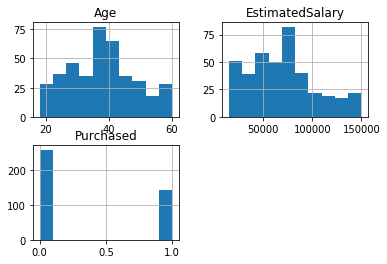

In [34]:
#dataset visualization
df.drop(['Gender'], axis = 1).hist()

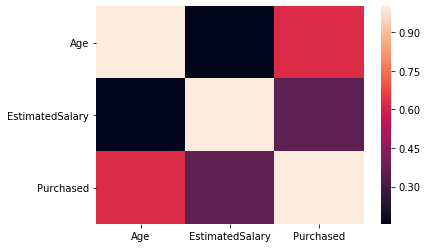

In [37]:
sns.heatmap(df.corr());

In [6]:
#Split dataSet into trainSet and testSet
X_train,X_test,y_train,y_test = train_test_split(df.drop('Purchased', axis =1), 
                                                 df['Purchased'], 
                                                 test_size = 0.2, 
                                                 stratify=df['Purchased'], 
                                                 random_state = 42)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,


((320, 3), (80, 3), (320,), (80,))

In [8]:
#Creating numerical features columns
num_columns = list(X_train.columns[X_train.dtypes != 'object'])
num_columns

['Age', 'EstimatedSalary']

In [9]:
#Creating categorical features columns
cat_columns = list(X_train.columns[X_train.dtypes == 'int64'])
cat_columns

['Age', 'EstimatedSalary']

In [10]:
#Creating numerical features column for binning
num_columns_for_bin = list(num_columns[:1])
num_columns_for_bin

['Age']

In [11]:
#Creating class which replaces negative 
#and changes to small positive values
class Replacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace_value=0.1):
        self.replace_value = replace_value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_replaced = np.where(X<=0, self.replace_value, X)
        return X_replaced
#Creating class for binning
class CustomBinning(BaseEstimator, TransformerMixin):
    def __init__(self, bins= [-np.inf, 18, 30, 40, np.inf]):
        self.bins = bins
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        bins = np .array(self.bins)
        X_bin = np.digitize(X, bins)
        return X_bin
        

In [12]:
#Creating pipeLine for categorical values
cat_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [13]:
#Creating pipeLine for numerical values
num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('replacer', Replacer(replace_value=0.1)),
    ('boxcox', PowerTransformer(method ='box-cox', standardize=True))
])

In [14]:
#Creating pipeLine for numerical values(binning)
num_bin_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('bin', CustomBinning()),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    
])

In [15]:
#Create a list of three-element tuples
transformers = [('num', num_pipe, num_columns),
               ('num_bin', num_bin_pipe, num_columns_for_bin),
                ('cat', cat_pipe, cat_columns)]

In [16]:
ct = ColumnTransformer(transformers=transformers)

In [17]:
#Final pipeline
logreg_pipe = Pipeline([
    ('transform', ct),
    ('logreg', LogisticRegression(solver='liblinear', random_state = 43))
])

In [18]:
#grid of parameters
param_grid = {
    'transform__num__imputer__strategy':['mean', 'median'],
    'transform__num__replacer__replace_value':[0.1, 0.2 , 0.3, 0.4, 0.5],
    'transform__cat__imputer__strategy':['most_frequent', 'constant'],
    'transform__num_bin__imputer__strategy':['mean', 'median'],
    'transform__num_bin__bin__bins':[[-np.inf, 18, 30, np.inf],
                                    [-np.inf, 18, 25, np.inf]],
    'logreg__C': [0.01, 0.1, 0.5, 1, 5 ,10]
}

In [19]:
gs = GridSearchCV(logreg_pipe ,param_grid, cv=5, return_train_score=False)

In [21]:
#GridSearch fit to train model
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                       

In [22]:
print('Best params:{}'.format(gs.best_params_))
print('Best score:{}'.format(gs.best_score_))
print('Test model\'s accuracy:{}'.format(gs.score(X_test, y_test)))

Best params:{'logreg__C': 1, 'transform__cat__imputer__strategy': 'most_frequent', 'transform__num__imputer__strategy': 'mean', 'transform__num__replacer__replace_value': 0.1, 'transform__num_bin__bin__bins': [-inf, 18, 30, inf], 'transform__num_bin__imputer__strategy': 'mean'}
Best score:0.8625
Test model's accuracy:0.8875


In [24]:
y_pred = gs.predict(X_test)

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[48,  3],
       [ 6, 23]], dtype=int64)

<h3>Fitting model to dataset</h3>

In [26]:
fulldata = pd.read_csv ('e:/job/ml/ads/Social_Network_Ads.csv')
y_fulldata = fulldata.pop ('Purchased')

In [27]:
#Use our best params
best_params = gs.best_params_

In [ ]:
#Set best params as default
logreg_pipe.set_params(**best_params)

In [ ]:
 logreg_pipe.fit(fulldata,y_fulldata)

In [35]:
print('Accuracy: {}'.format(logreg_pipe.score(fulldata,y_fulldata)))

Accuracy: 0.92
